# USAD
## Importing packages

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

## Reading data

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed(439)

In [4]:
df = pd.read_csv('../../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')

### Processing data

In [5]:
window_size = 12
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 20

In [6]:
mm = StandardScaler()

In [7]:
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


In [9]:
#device = torch.device('cpu')

In [10]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

In [11]:
train_dataset = SWat_dataset(train_set, train_set, window_size)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Setting up the model structure

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(input_size // 2, input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, hidden_size)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        return out


class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder):        
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(hidden_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 2)
        self.fc3 = nn.Linear(input_size // 2, input_size)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [13]:
shared_encoder = Encoder(input_size, latent_space)
AE1 = AutoEncoder(input_size, latent_space, shared_encoder)
AE2 = AutoEncoder(input_size, latent_space, shared_encoder)

In [14]:
shared_encoder.to(device)
AE1.to(device)
AE2.to(device)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=612, out_features=306, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=306, out_features=153, bias=True)
    (fc3): Linear(in_features=153, out_features=120, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=120, out_features=153, bias=True)
  (fc2): Linear(in_features=153, out_features=306, bias=True)
  (fc3): Linear(in_features=306, out_features=612, bias=True)
)

In [15]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

## Training the model

### Training

In [16]:
%%time
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = features.view(features.shape[0], -1)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = features.view(features.shape[0], -1)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.0813, AE2: 0.0822
Train loss: AE1 0.2229, AE2 0.2192
Epoch: 1 ---> Val loss: AE1 0.2121, AE2: -0.0876
Train loss: AE1 0.3612, AE2 -0.1515
Epoch: 2 ---> Val loss: AE1 0.3284, AE2: -0.2739
Train loss: AE1 0.6078, AE2 -0.5157
Epoch: 3 ---> Val loss: AE1 0.3483, AE2: -0.3137
Train loss: AE1 0.6955, AE2 -0.6507
Epoch: 4 ---> Val loss: AE1 0.3598, AE2: -0.3358
Train loss: AE1 0.7211, AE2 -0.6944
Epoch: 5 ---> Val loss: AE1 0.3730, AE2: -0.3530
Train loss: AE1 0.7463, AE2 -0.7255
Epoch: 6 ---> Val loss: AE1 0.3793, AE2: -0.3634
Train loss: AE1 0.7723, AE2 -0.7412
Epoch: 7 ---> Val loss: AE1 0.3946, AE2: -0.3676
Train loss: AE1 0.7825, AE2 -0.7541
Epoch: 8 ---> Val loss: AE1 0.3901, AE2: -0.3772
Train loss: AE1 0.7932, AE2 -0.7705
Epoch: 9 ---> Val loss: AE1 0.3911, AE2: -0.3815
Train loss: AE1 0.8023, AE2 -0.7776
Epoch: 10 ---> Val loss: AE1 0.3970, AE2: -0.3866
Train loss: AE1 0.8030, AE2 -0.7914
Epoch: 11 ---> Val loss: AE1 0.3978, AE2: -0.3894
Train loss: AE1 

In [17]:
def plot_history(losses1, losses2):
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.savefig('Training_history.png')
    plt.show()

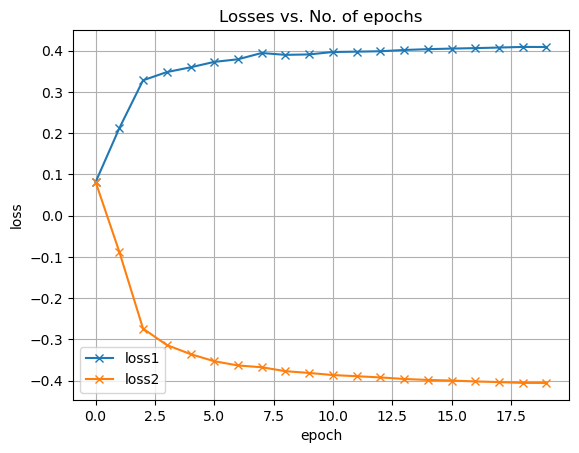

In [18]:
plot_history(AE1_val_history, AE2_val_history)

In [19]:
# torch.save(AE1.state_dict(), 'my_USAD_without_downsampling_AE1_hidden_10_random.pth')
# torch.save(AE2.state_dict(), 'my_USAD_without_downsampling_AE2_hidden_10_random.pth')

In [20]:
# AE1.load_state_dict(torch.load('my_USAD_without_downsampling_AE1_100_hidden.pth'))
# AE2.load_state_dict(torch.load('my_USAD_without_downsampling_AE2_100_hidden.pth'))

## Testing

In [21]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns

In [22]:
test_normalized = pd.DataFrame(mm.transform(df2))

In [23]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [24]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.view(batch.shape[0], -1)
            w1=AE1(batch)
            w2=AE2(w1)
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [25]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]

In [26]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [27]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [28]:
results=testing(test_loader)

In [29]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), 
                       results[-1].flatten().detach().cpu().numpy()])

In [30]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

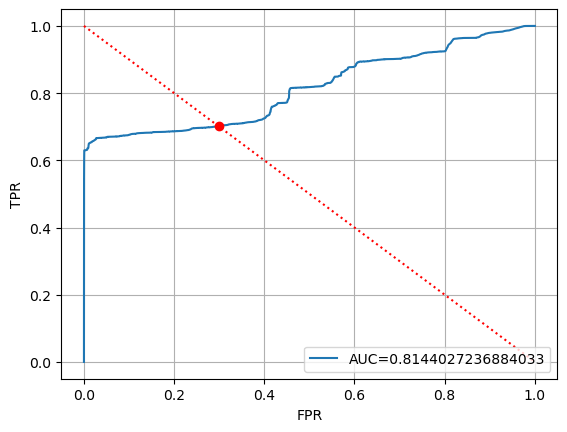

In [31]:
threshold = ROC(y_test,y_pred)

In [32]:
threshold

array([5.8593016], dtype=float32)

best: 13.0 F1: 0.7703548828363936


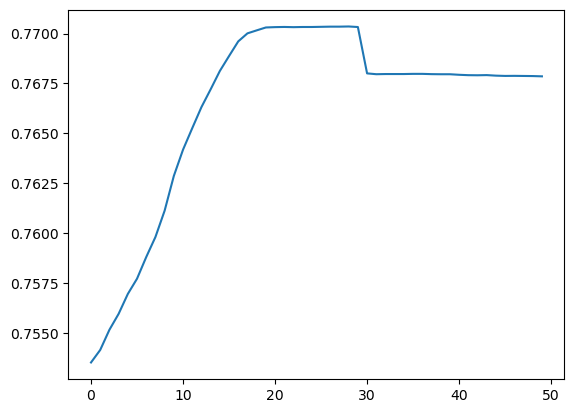

In [33]:
ff = 0
f_history = []
initial_y = 9
best = -1
for inc in np.linspace(0, 7, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

# Try adjust point

In [34]:
labels = labels[12:]
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

## Point Adjust

best: 7.571428571428571 F1: 0.8309503450195876


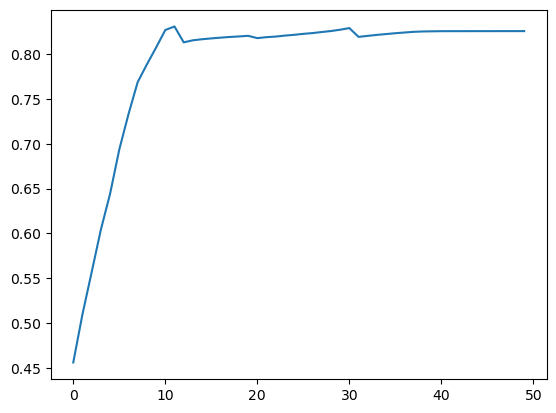

In [35]:
ff = 0
f_history = []
initial_y = 6
best = -1
for inc in np.linspace(0, 7, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

## Point Adjust 20%

best: 13.0 F1: 0.8257831581182967


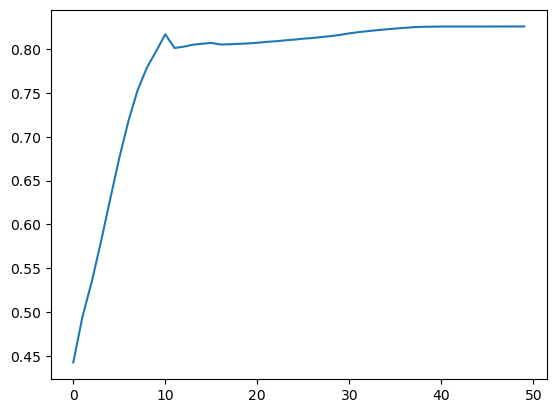

In [36]:
ff = 0
f_history = []
initial_y = 6
best = -1
for inc in np.linspace(0, 7, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) / (j - i) > 0.3:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

## Visualization

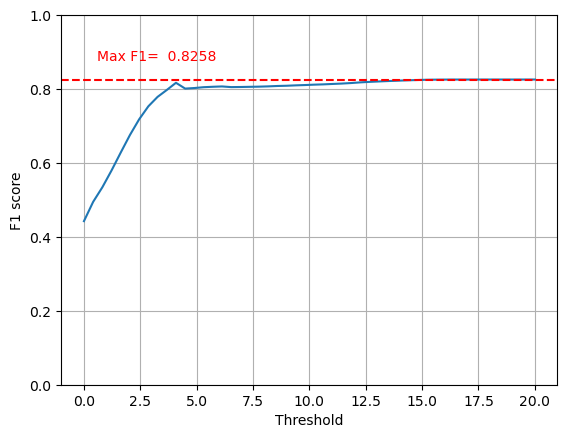

In [37]:
x_vals = 0. + np.linspace(0, 20, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

# plt.savefig('my_plot.png')

plt.show()

In [39]:
sum1 = sum(p.numel() for p in AE1.parameters() if p.requires_grad)
sum2 = sum(p.numel() for p in AE2.parameters() if p.requires_grad)
sum3 = sum(p.numel() for p in shared_encoder.parameters() if p.requires_grad)
print(sum1 + sum2 - sum3)

760071
